In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
from scipy.optimize import curve_fit
%matplotlib inline

In [12]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, vertices, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    ### All Lines
    LineInfo = []
    for pltline in lines:
        for x1,y1,x2,y2 in pltline:
            #plt.plot([x1, x2], [y1, y2])
            LineInfo.extend([(y2-y1)/(x2-x1)])
    LinePos = [i for i in LineInfo if i > 0 and abs(i) > 0.2 and abs(i) < 2]
    LineNeg = [i for i in LineInfo if i <= 0 and abs(i) > 0.2 and abs(i) < 2]
    
    SlopeThd = 0.2
    if not len(LineNeg):
        NegLines = []
    else:
        LineAbsNeg = sum(LineNeg)/len(LineNeg)
        LineNegLim = [i for i in LineNeg if abs(i-LineAbsNeg) < SlopeThd]
        NegLines = [lines[LineInfo.index(i)] for i in LineNegLim]
    
    if not len(LinePos):
        PosLines = []
    else:
        LineAbsPos = sum(LinePos)/len(LinePos)
        LinePosLim = [i for i in LinePos if abs(i-LineAbsPos) < SlopeThd]
        PosLines = [lines[LineInfo.index(i)] for i in LinePosLim]
        
    xCurveDataNeg = np.array([])
    yCurveDataNeg = np.array([])
    if len(NegLines):
        for pltline in NegLines:
            for x1,y1,x2,y2 in pltline:
                #plt.plot([x1, x2], [y1, y2],'*k')
                xCurveDataNeg = np.concatenate((xCurveDataNeg,np.array([x1, x2])))
                yCurveDataNeg = np.concatenate((yCurveDataNeg,np.array([y1, y2])))
        xLimNeg = image.shape[1]/2
        SearchIndexNeg = (xCurveDataNeg < xLimNeg)
        yCurveDataNeg = yCurveDataNeg[SearchIndexNeg]
        xCurveDataNeg = xCurveDataNeg[SearchIndexNeg]
        
    xCurveDataPos = np.array([])
    yCurveDataPos = np.array([])
    if len(PosLines):
        for pltline in PosLines:
            for x1,y1,x2,y2 in pltline:
                #plt.plot([x1, x2], [y1, y2],'*k')
                xCurveDataPos = np.concatenate((xCurveDataPos,np.array([x1, x2])))
                yCurveDataPos = np.concatenate((yCurveDataPos,np.array([y1, y2])))
        xLimPos = image.shape[1]/2
        SearchIndexPos = (xCurveDataPos > xLimPos)
        yCurveDataPos = yCurveDataPos[SearchIndexPos]
        xCurveDataPos = xCurveDataPos[SearchIndexPos]
    
    def CurveFitFunc(x, a, b):
        return a * x + b
    def CurveFitFuncInv(y, a, b):
        return (y-b) / a
    
    if not yCurveDataNeg.any():
        LineNeg = []
    else:
        popt, pcov = curve_fit(CurveFitFunc, xCurveDataNeg, yCurveDataNeg)
        yLimNeg = vertices[0][1][1]
        yMax = img.shape[0]
        xStartNeg = CurveFitFuncInv(yMax, *popt)
        xEndNeg = CurveFitFuncInv(yLimNeg, *popt)
        LineNeg = [xStartNeg,yMax,xEndNeg,yLimNeg]
        LineNeg = [int(i) for i in LineNeg]
    #plt.plot(xCurveDataNeg, CurveFitFunc(xCurveDataNeg, *popt), 'r-',)
    
    if not yCurveDataPos.any():
        LinePos = [] 
    else:
        popt, pcov = curve_fit(CurveFitFunc, xCurveDataPos, yCurveDataPos)
        yLimPos = vertices[0][2][1]
        yMax = img.shape[0]
        xStartPos = CurveFitFuncInv(yMax, *popt)
        xEndPos = CurveFitFuncInv(yLimPos, *popt)
        LinePos = [xStartPos,yMax,xEndPos,yLimPos]
        LinePos = [int(i) for i in LinePos]
    #plt.plot(xCurveDataPos, CurveFitFunc(xCurveDataPos, *popt), 'r-',)
    LinesFit = np.array([[LineNeg],[LinePos]])
    #for pltline in LinesFit:
        #for x1,y1,x2,y2 in pltline:
            #plt.plot([x1, x2], [y1, y2])
    
    if LinesFit.any():
        for line in LinesFit:
            for x1,y1,x2,y2 in line:
                cv2.line(img,(x1,y1),(x2,y2),color,thickness)


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines, vertices)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

In [13]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    gray = grayscale(image)
    plt.imshow(gray, cmap='gray')
    plt.show()

    kernel_size = 5
    blur_gray = gaussian_blur(gray, kernel_size)
    plt.imshow(blur_gray, cmap='gray')
    plt.show()

    low_threshold = 50
    high_threshold = 150
    masked_edges = canny(image, low_threshold, high_threshold)
    plt.imshow(masked_edges, cmap='gray')
    plt.show()

    imshape = image.shape
    xUpperLeft = 470
    xUpperRight = 490
    yUpper = 315
    vertices = np.array([[(0,imshape[0]),(xUpperLeft, yUpper), (xUpperRight, yUpper), (imshape[1],imshape[0])]], dtype=np.int32)
    masked_image = region_of_interest(masked_edges, vertices)
    plt.imshow(masked_image, cmap='gray')
    plt.show()

    rho = 2
    theta = 1*np.pi/180
    threshold = 15
    min_line_len = 20
    max_line_gap = 25
    line_img = hough_lines(masked_image, rho, theta, threshold, min_line_len, max_line_gap)
    plt.imshow(line_img)
    plt.show()

    color_edges = np.dstack((masked_edges, masked_edges, masked_edges))
    combox = cv2.addWeighted(color_edges, 0.8, line_img, 1, 0) 
    plt.imshow(combox)
    plt.show()

    result = weighted_img(line_img, image, α=0.8, β=1., γ=0.)
    plt.imshow(result)
    plt.show()
    return result 

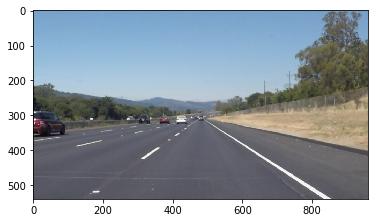

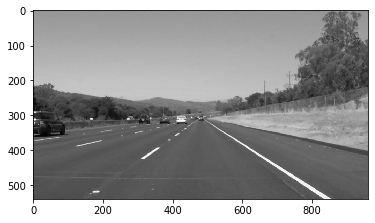

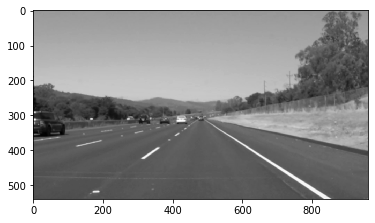

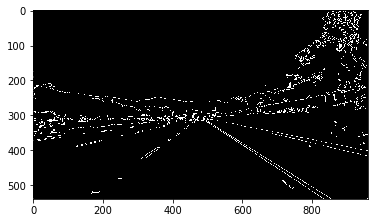

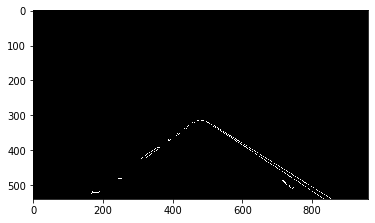

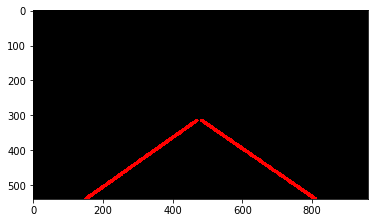

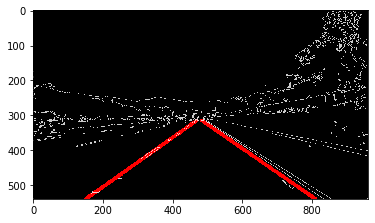

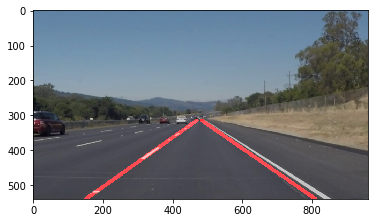

In [15]:
image = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')
image = mpimg.imread('test_images/solidWhiteRight.jpg')
plt.imshow(image)
plt.show()
imageOut = process_image(image)

In [35]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
from scipy.optimize import curve_fit
def Init(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) #grayscale conversion
    #plt.imshow(gray, cmap='gray')
    # Define a kernel size for Gaussian smoothing / blurring
    # Note: this step is optional as cv2.Canny() applies a 5x5 Gaussian internally
    kernel_size = 5
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size), 0)

    # Define parameters for Canny and run it
    # NOTE: if you try running this code you might want to change these!
    low_threshold = 50
    high_threshold = 150
    masked_edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

    # Next we'll create a masked edges image using cv2.fillPoly()
    mask = np.zeros_like(masked_edges)   
    ignore_mask_color = 255   

    # This time we are defining a four sided polygon to mask
    imshape = image.shape
    xUpperLeft = 600
    xUpperRight = 640
    yUpper = 380
    xUpperLeft = 470
    xUpperRight = 490
    yUpper = 315
    vertices = np.array([[(0,imshape[0]),(xUpperLeft, yUpper), (xUpperRight, yUpper), (imshape[1],imshape[0])]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_edges = cv2.bitwise_and(masked_edges, mask)
    # Display the image
    #plt.imshow(masked_edges, cmap='Greys_r')
    #plt.show()
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 2
    theta = 1*np.pi/180
    threshold = 15
    min_line_length = 20
    max_line_gap = 25
    line_image = np.copy(image)*0 #creating a blank to draw lines on
    # Run Hough on edge detected image
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                                min_line_length, max_line_gap) 
    return lines, vertices, masked_edges

def edit1(lines):
    ### All Lines
    LineInfo = []
    for pltline in lines:
        for x1,y1,x2,y2 in pltline:
            #plt.plot([x1, x2], [y1, y2])
            LineInfo.extend([(y2-y1)/(x2-x1)])
    LinePos = [i for i in LineInfo if i > 0 and abs(i) > 0.2 and abs(i) < 2]
    LineNeg = [i for i in LineInfo if i <= 0 and abs(i) > 0.2 and abs(i) < 2]
    
    SlopeThd = 0.2
    if not len(LineNeg):
        NegLines = []
    else:
        LineAbsNeg = sum(LineNeg)/len(LineNeg)
        LineNegLim = [i for i in LineNeg if abs(i-LineAbsNeg) < SlopeThd]
        NegLines = [lines[LineInfo.index(i)] for i in LineNegLim]
    
    if not len(LinePos):
        PosLines = []
    else:
        LineAbsPos = sum(LinePos)/len(LinePos)
        LinePosLim = [i for i in LinePos if abs(i-LineAbsPos) < SlopeThd]
        PosLines = [lines[LineInfo.index(i)] for i in LinePosLim]
    
    return NegLines, PosLines, LineInfo
def edit2(NegLines, PosLines, image, LineInfo, vertices):
    
    xCurveDataNeg = np.array([])
    yCurveDataNeg = np.array([])
    if len(NegLines):
        for pltline in NegLines:
            for x1,y1,x2,y2 in pltline:
                #plt.plot([x1, x2], [y1, y2],'*k')
                xCurveDataNeg = np.concatenate((xCurveDataNeg,np.array([x1, x2])))
                yCurveDataNeg = np.concatenate((yCurveDataNeg,np.array([y1, y2])))
        xLimNeg = image.shape[1]/2
        SearchIndexNeg = (xCurveDataNeg < xLimNeg)
        #SearchIndexNeg = (xCurveDataNeg < xLimNeg) & (xCurveDataNeg > (sum(xCurveDataNeg)/len(xCurveDataNeg))-(xLimNeg/2))   
        yCurveDataNeg = yCurveDataNeg[SearchIndexNeg]
        xCurveDataNeg = xCurveDataNeg[SearchIndexNeg]
        
    
    xCurveDataPos = np.array([])
    yCurveDataPos = np.array([])
    if len(PosLines):
        for pltline in PosLines:
            for x1,y1,x2,y2 in pltline:
                #plt.plot([x1, x2], [y1, y2],'*k')
                xCurveDataPos = np.concatenate((xCurveDataPos,np.array([x1, x2])))
                yCurveDataPos = np.concatenate((yCurveDataPos,np.array([y1, y2])))
        xLimPos = image.shape[1]/2
        SearchIndexPos = (xCurveDataPos > xLimPos)
        #SearchIndexPos = (xCurveDataPos > xLimPos) & (xCurveDataPos < (sum(xCurveDataPos)/len(xCurveDataPos))+(xLimPos/2))
        yCurveDataPos = yCurveDataPos[SearchIndexPos]
        xCurveDataPos = xCurveDataPos[SearchIndexPos]
    
    def CurveFitFunc(x, a, b):
        return a * x + b
    def CurveFitFuncInv(y, a, b):
        return (y-b) / a
    
    if not yCurveDataNeg.any():
        LineNeg = []
    else:
        popt, pcov = curve_fit(CurveFitFunc, xCurveDataNeg, yCurveDataNeg)
        yLimNeg = vertices[0][1][1]
        #yLimNeg = yLimNeg + 50
        yMax = image.shape[0]
        xStartNeg = CurveFitFuncInv(yMax, *popt)
        xEndNeg = CurveFitFuncInv(yLimNeg, *popt)
        LineNeg = [xStartNeg,yMax,xEndNeg,yLimNeg]
        LineNeg = [int(i) for i in LineNeg]
    #plt.plot(xCurveDataNeg, CurveFitFunc(xCurveDataNeg, *popt), 'r-',)
    
    if not yCurveDataPos.any():
        LinePos = [] 
    else:
        popt, pcov = curve_fit(CurveFitFunc, xCurveDataPos, yCurveDataPos)
        yLimPos = vertices[0][2][1]
        #yLimPos = yLimPos + 50
        yMax = image.shape[0]
        xStartPos = CurveFitFuncInv(yMax, *popt)
        xEndPos = CurveFitFuncInv(yLimPos, *popt)
        LinePos = [xStartPos,yMax,xEndPos,yLimPos]
        LinePos = [int(i) for i in LinePos]
    #plt.plot(xCurveDataPos, CurveFitFunc(xCurveDataPos, *popt), 'r-',)
    LinesFit = np.array([[LineNeg],[LinePos]])
    #for pltline in LinesFit:
        #for x1,y1,x2,y2 in pltline:
            #plt.plot([x1, x2], [y1, y2])
    return LinesFit
def edit3(image, LinesFit, masked_edges):
    if not LinesFit.any():
        UpdatedPicture = image
    else:
        line_imageFit = np.copy(image)*0 #creating a blank to draw lines on
        for line in LinesFit:
            for x1,y1,x2,y2 in line:
                cv2.line(line_imageFit,(x1,y1),(x2,y2),(0,0,255),10)
        color_edges = np.dstack((masked_edges, masked_edges, masked_edges)) 
        # Draw the lines on the edge image
        combox = cv2.addWeighted(color_edges, 0.8, line_imageFit, 1, 0) 
        #plt.show()
        #plt.imshow(combox)

        UpdatedPicture = cv2.addWeighted(image, 1, line_imageFit, 1, 0)
    return UpdatedPicture

In [13]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
from scipy.optimize import curve_fit
from IPython.core.debugger import set_trace

cap = cv2.VideoCapture('test_videos/solidWhiteRight.mp4')
#cap = cv2.VideoCapture('test_videos/solidYellowLeft.mp4')
#cap = cv2.VideoCapture('test_videos/challenge.mp4')
vid_cod = cv2.VideoWriter_fourcc(*'XVID')
#output = cv2.VideoWriter("video.mp4", vid_cod, 20.0, (640,480))
count = 0
ctr = 0
while(cap.isOpened()):
    ret, frame = cap.read()
    name = "fff/frame%d.jpg"%ctr
    #cv2.imwrite(name, frame)
    #print(ctr,ret)
    #cv2.waitKey(5)
    if ret:

        
        lines, vertices, masked_edges = Init(frame)
        LineNegLim, LinePosLim, LineInfo = edit1(lines)
        LinesFit = edit2(LineNegLim, LinePosLim, frame, LineInfo, vertices)
        UpdatedPicture = edit3(frame, LinesFit, masked_edges)   

        #cv2.imwrite(name, frame)
        cv2.imshow('frame',UpdatedPicture)
        count +=1
        #cv2.waitKey(5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    ctr += 1
cap.release()
cv2.destroyAllWindows()

In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
from scipy.optimize import curve_fit
image = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')
#image = mpimg.imread('fff/frame0.jpg')
lines, vertices, masked_edges = Init(image)
LineNegLim, LinePosLim, LineInfo = edit1(lines)
LinesFit = edit2(LineNegLim, LinePosLim, image, LineInfo, vertices)
UpdatedPicture = edit3(image, LinesFit, masked_edges)
plt.imshow(UpdatedPicture)

NameError: name 'Init' is not defined

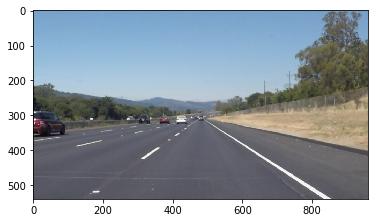

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
from scipy.optimize import curve_fit
#image = mpimg.imread('test_images/solidWhiteCurve.jpg')
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#image = mpimg.imread('test_images/solidYellowCurve.jpg')
#image = mpimg.imread('test_images/solidYellowCurve2.jpg')
#image = mpimg.imread('test_images/solidYellowLeft.jpg')
#image = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')
plt.imshow(image)

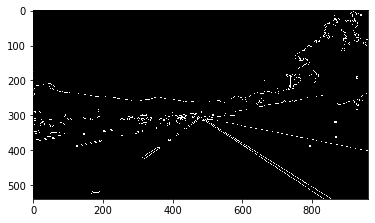

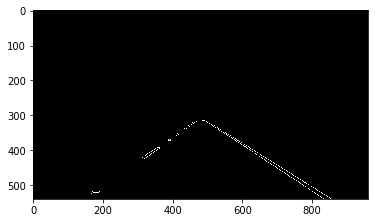

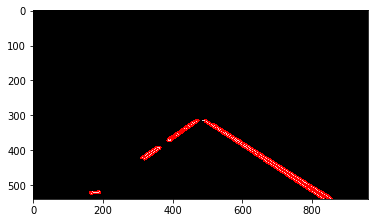

In [11]:
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) #grayscale conversion
#plt.imshow(gray, cmap='gray')
# Define a kernel size for Gaussian smoothing / blurring
# Note: this step is optional as cv2.Canny() applies a 5x5 Gaussian internally
kernel_size = 5
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size), 0)

# Define parameters for Canny and run it
# NOTE: if you try running this code you might want to change these!
low_threshold = 50
high_threshold = 150
masked_edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
plt.imshow(masked_edges, cmap='Greys_r')
plt.show()
# Next we'll create a masked edges image using cv2.fillPoly()
mask = np.zeros_like(masked_edges)   
ignore_mask_color = 255   

# This time we are defining a four sided polygon to mask
imshape = image.shape
xUpperLeft = 470
xUpperRight = 490
yUpper = 315
vertices = np.array([[(0,imshape[0]),(xUpperLeft, yUpper), (xUpperRight, yUpper), (imshape[1],imshape[0])]], dtype=np.int32)
cv2.fillPoly(mask, vertices, ignore_mask_color)
masked_edges = cv2.bitwise_and(masked_edges, mask)
# Display the image
plt.imshow(masked_edges, cmap='Greys_r')
plt.show()
# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 2
theta = 1*np.pi/180
threshold = 15
min_line_length = 25
max_line_gap = 20
line_image = np.copy(image)*0 #creating a blank to draw lines on
# Run Hough on edge detected image
lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)       
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)
color_edges = np.dstack((masked_edges, masked_edges, masked_edges)) 
# Draw the lines on the edge image
combox = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 
plt.imshow(combox)
plt.show()

Absolute average slope of all lines: 0.6263809782592263
Average slope of negative lines after length rating: -0.6967551175011304
Average slope of positive lines after length rating: 0.6399654533950732


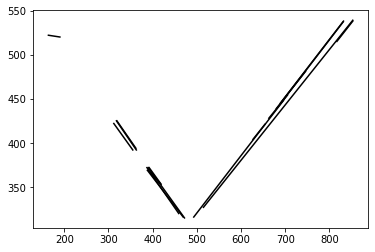

In [3]:
### All Lines
i = 0
LineInfo = [[0] * len(lines), [0] * len(lines)]
for pltline in lines:
    for x1,y1,x2,y2 in pltline:
        plt.plot([x1, x2], [y1, y2],'k')
        LineInfo[0][i] = ((y2-y1)/(x2-x1))
        LineInfo[1][i] = ((y2-y1)**2 + (x2-x1)**2)**(1/2)
        i = i + 1
LinePos = [i for i in LineInfo[0] if i > 0 and abs(i) > 0.3]
LinePosLen = [LineInfo[1][LineInfo[0].index(i)] for i in LineInfo[0] if i > 0]
LineNeg = [i for i in LineInfo[0] if i <= 0 and abs(i) > 0.3]
LineNegLen = [LineInfo[1][LineInfo[0].index(i)] for i in LineInfo[0] if i <= 0]
LineAbs = sum(list(map(abs, LineInfo[0])))/len(LineInfo[0])
print('Absolute average slope of all lines:' , LineAbs)
### Negative Lines: Compare to overall slope value
SlopeThd = 0.05
LineAbsNeg = sum(LineNeg)/len(LineNeg)
LineNegLim = [i for i in LineNeg if abs(i-LineAbsNeg) < SlopeThd]
LineNegLenLim = [LineInfo[1][LineInfo[0].index(i)] for i in LineNegLim]
AveNegRate = [(i-min(LineNegLenLim))/(max(LineNegLenLim)-min(LineNegLenLim)) for i in LineNegLenLim]
LineNegLimRated = [i*LineNegLim[AveNegRate.index(i)] for i in AveNegRate]
SlopeNeg = sum(LineNegLimRated)/sum(AveNegRate)
print('Average slope of negative lines after length rating:' , SlopeNeg)
### Positive Lines: Compare to overall slope value
LineAbsPos = sum(LinePos)/len(LinePos)
LinePosLim = [i for i in LinePos if abs(i-LineAbsPos) < SlopeThd]
LinePosLenLim = [LineInfo[1][LineInfo[0].index(i)] for i in LinePosLim]
AvePosRate = [(i-min(LinePosLenLim))/(max(LinePosLenLim)-min(LinePosLenLim)) for i in LinePosLenLim]
LinePosLimRated = [i*LinePosLim[AvePosRate.index(i)] for i in AvePosRate]
SlopePos = sum(LinePosLimRated)/sum(AvePosRate)
print('Average slope of positive lines after length rating:' , SlopePos)
### (x,y) points after slope based elimination

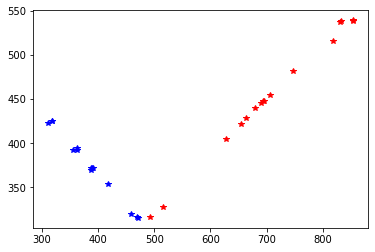

In [4]:
NegLines = [lines[LineInfo[0].index(i)] for i in LineNegLim]
xCurveDataNeg = np.array([])
yCurveDataNeg = np.array([])
for pltline in NegLines:
    for x1,y1,x2,y2 in pltline:
        plt.plot([x1, x2], [y1, y2],'*b')
        xCurveDataNeg = np.concatenate((xCurveDataNeg,np.array([x1, x2])))
        yCurveDataNeg = np.concatenate((yCurveDataNeg,np.array([y1, y2])))

PosLines = [lines[LineInfo[0].index(i)] for i in LinePosLim]
xCurveDataPos = np.array([])
yCurveDataPos = np.array([])
for pltline in PosLines:
    for x1,y1,x2,y2 in pltline:
        plt.plot([x1, x2], [y1, y2],'*r')
        xCurveDataPos = np.concatenate((xCurveDataPos,np.array([x1, x2])))
        yCurveDataPos = np.concatenate((yCurveDataPos,np.array([y1, y2])))
#plt.plot(xCurveDataPos, CurveFitFunc(xCurveDataPos, *popt), 'r-',)


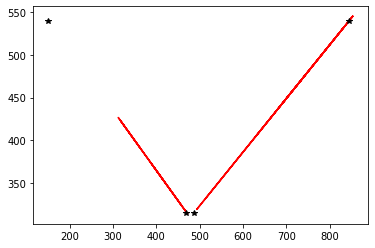

In [5]:
###
def CurveFitFunc(x, a, b):
    return a * x + b
def CurveFitFuncInv(y, a, b):
    return (y-b) / a
popt, pcov = curve_fit(CurveFitFunc, xCurveDataNeg, yCurveDataNeg)
yLimNeg = vertices[0][1][1]
yMax = image.shape[0]
xStartNeg = CurveFitFuncInv(yMax, *popt)
xEndNeg = CurveFitFuncInv(yLimNeg, *popt)
LineNeg = [xStartNeg,yMax,xEndNeg,yLimNeg]
LineNeg = [int(i) for i in LineNeg]
plt.plot(xCurveDataNeg, CurveFitFunc(xCurveDataNeg, *popt), 'r-',)
popt, pcov = curve_fit(CurveFitFunc, xCurveDataPos, yCurveDataPos)
yLimPos = vertices[0][2][1]
yMax = image.shape[0]
xStartPos = CurveFitFuncInv(yMax, *popt)
xEndPos = CurveFitFuncInv(yLimPos, *popt)
LinePos = [xStartPos,yMax,xEndPos,yLimPos]
LinePos = [int(i) for i in LinePos]
plt.plot(xCurveDataPos, CurveFitFunc(xCurveDataPos, *popt), 'r-',)
LinesFit = np.array([[LineNeg],[LinePos]])
for pltline in LinesFit:
    for x1,y1,x2,y2 in pltline:
        plt.plot([x1, x2], [y1, y2],'*k')

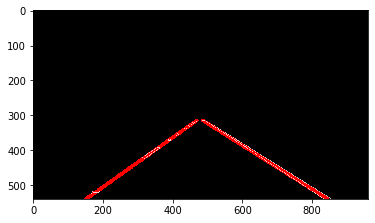

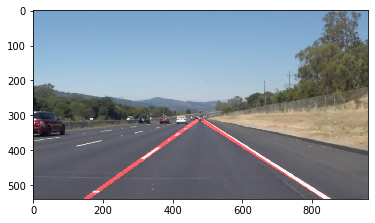

In [6]:
line_imageFit = np.copy(image)*0 #creating a blank to draw lines on
for line in LinesFit:
    for x1,y1,x2,y2 in line:
        cv2.line(line_imageFit,(x1,y1),(x2,y2),(255,0,0),10)
color_edges = np.dstack((masked_edges, masked_edges, masked_edges)) 
# Draw the lines on the edge image
combox = cv2.addWeighted(color_edges, 0.8, line_imageFit, 1, 0) 
plt.imshow(combox)
plt.show()
UpdatedPicture = cv2.addWeighted(image, 1, line_imageFit, 1, 0)
plt.imshow(UpdatedPicture)

In [23]:
xPosAve = sum(xCurveDataNeg)/len(xCurveDataNeg)
abs(xCurveDataNeg-xPosAve)<

array([-71.4, -26.4, -60.4, -18.4,   5.6,  54.6,   6.6,  63.6, -64.4,
       -21.4,   8.6,  57.6,   5.6,  55.6,  10.6,  37.6,  10.6,  35.6,
       -64.4, -25.4])